In [1]:
import numpy as np
import torch
from data.synthetic_dataset import * #create_synthetic_dataset, SyntheticDataset , ECG5000Dataset,load_ECG5000
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
random.seed(0)

# parameters

# Load synthetic dataset
# X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
# dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
# dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
# trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
# testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)

# N_input = 84
# N_output = 56
# # Load ECG dataset
# filepath_train = '/cvlabdata2/cvlab/datasets_yiwang/ECG5000_TRAIN.txt'
# filepath_test = '/cvlabdata2/cvlab/datasets_yiwang/ECG5000_TEST.txt'
# x_train_ip, x_train_op, x_test_ip, x_test_op, train_bkp, test_bkp = load_ECG5000(filepath_train, filepath_test)
# # print (x_train_ip.shape, x_train_op.shape, x_test_ip.shape, x_test_op.shape)
# dataset_train = ECG5000Dataset(x_train_ip, x_train_op, train_bkp)
# dataset_test  = ECG5000Dataset(x_test_ip, x_test_op, test_bkp)
# trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
# testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)


# Traffic Analysis
batch_size = 25
N_input = 168
N_output = 24
sigma = 0.01
gamma = 0.01

loc = '/cvlabdata2/cvlab/datasets_yiwang/traffic.txt'
# Load Min Temp dataset
x_train_ip, x_train_op, x_test_ip, x_test_op, train_bkp, test_bkp = load_traffic(loc)
# print (x_train_ip.shape, x_train_op.shape, x_test_ip.shape, x_test_op.shape)
dataset_train = ECG5000Dataset(x_train_ip, x_train_op, train_bkp)
dataset_test  = ECG5000Dataset(x_test_ip, x_test_op, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)




def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
            
            if (loss_type=='dilate_shape'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
                loss = loss_shape
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)
  

 
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 


encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate_shape = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate_shape,loss_type='dilate_shape',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)



epoch  0  loss  0.7836034893989563  loss shape  1.5360684394836426  loss temporal  0.03113858588039875
 Eval mse=  0.06114259362220764  dtw=  1.2092297110177206  tdi=  0.0
epoch  50  loss  -0.056458428502082825  loss shape  -0.3059852123260498  loss temporal  0.19306835532188416
 Eval mse=  0.001437835511751473  dtw=  0.14925482868055714  tdi=  0.27770833333333333
epoch  100  loss  -0.07113327085971832  loss shape  -0.32549914717674255  loss temporal  0.1832326054573059
 Eval mse=  0.0011020211968570948  dtw=  0.11522698372866629  tdi=  0.17277777777777778
epoch  150  loss  -0.06370262056589127  loss shape  -0.3263697624206543  loss temporal  0.19896452128887177
 Eval mse=  0.0010733191156759858  dtw=  0.11053148179499248  tdi=  0.16013888888888894
epoch  200  loss  -0.06376529484987259  loss shape  -0.31925302743911743  loss temporal  0.19172243773937225
 Eval mse=  0.0010593170300126076  dtw=  0.11089615510718161  tdi=  0.11763888888888888
epoch  250  loss  -0.06040632724761963  loss

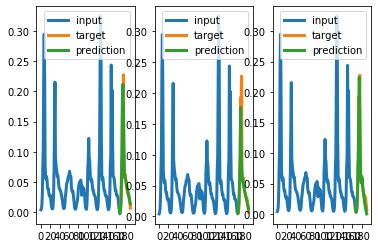

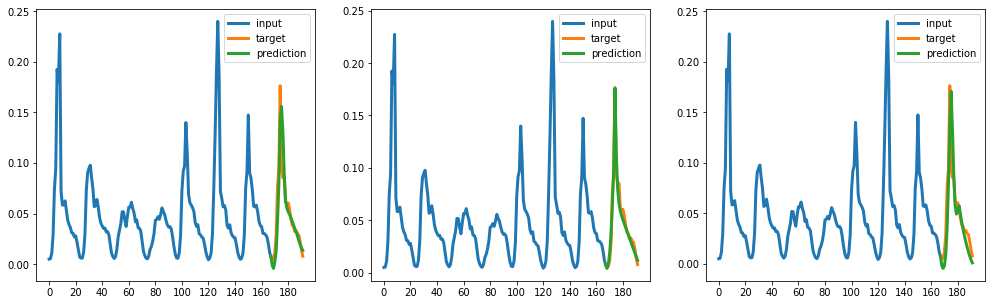

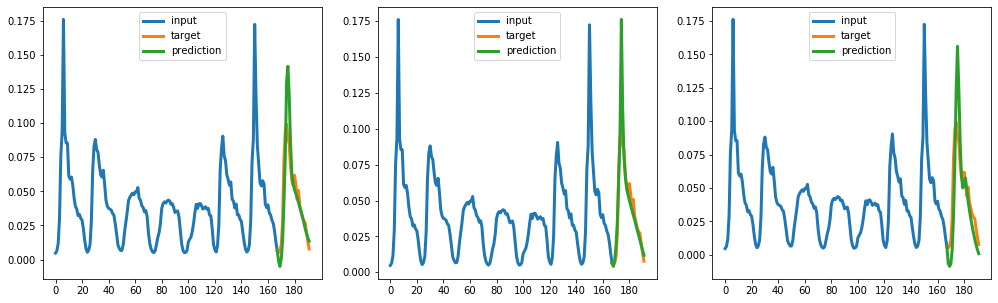

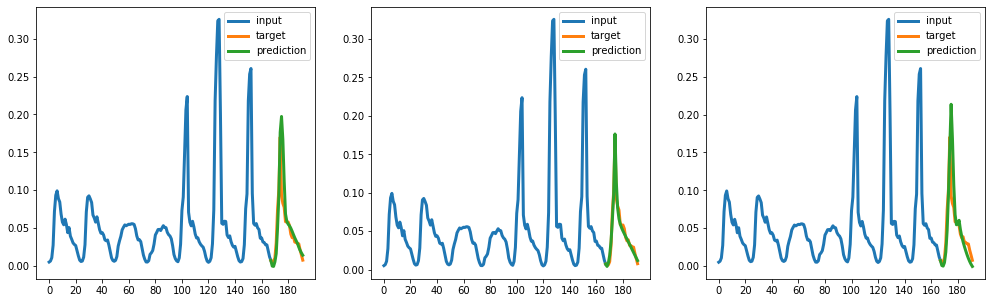

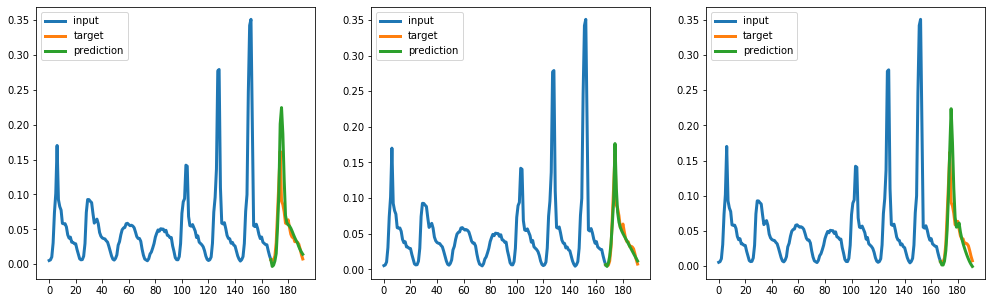

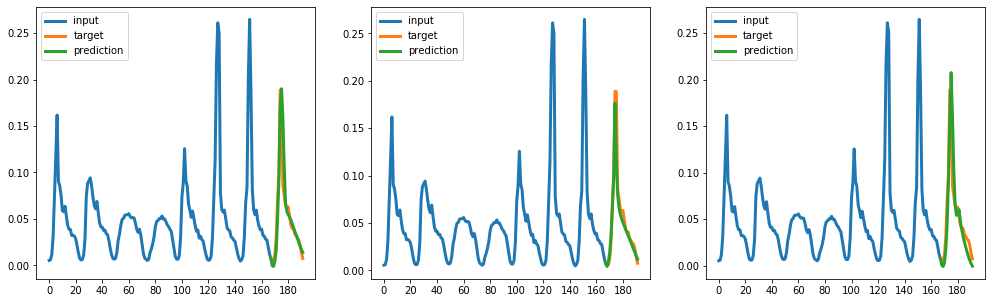

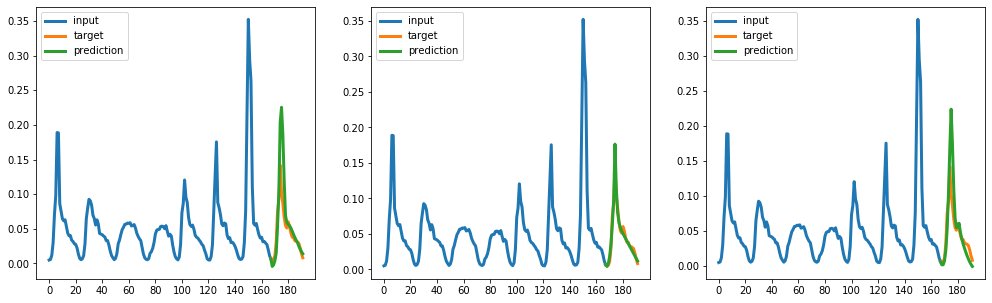

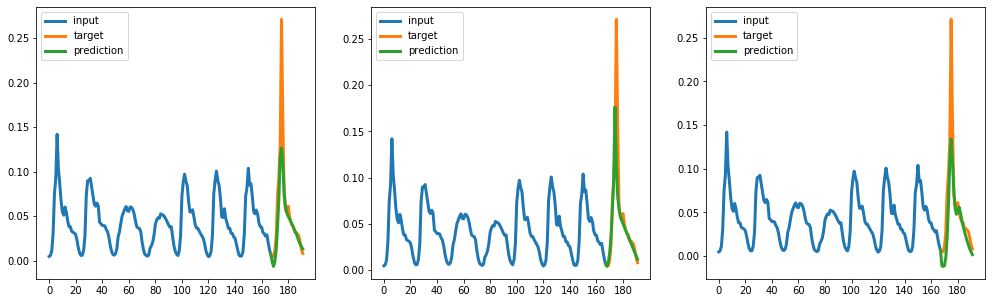

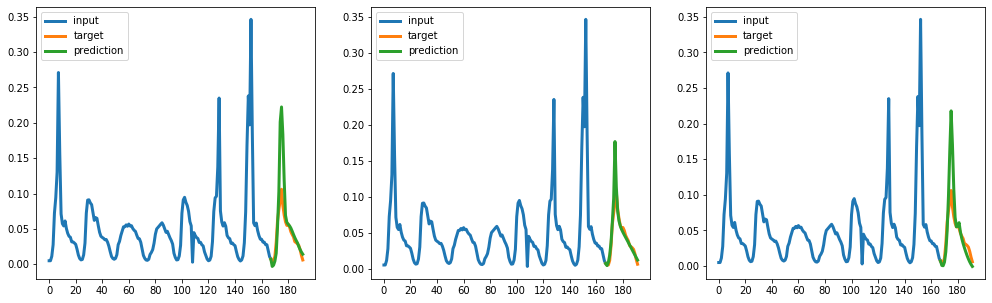

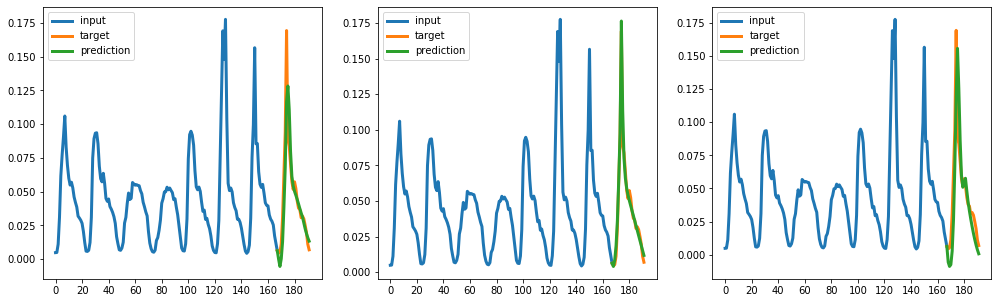

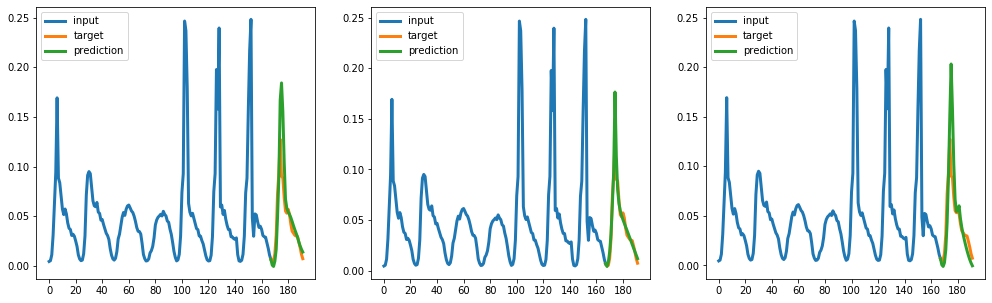

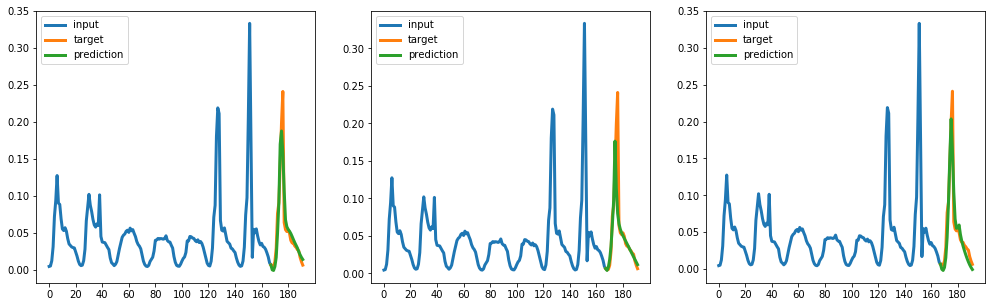

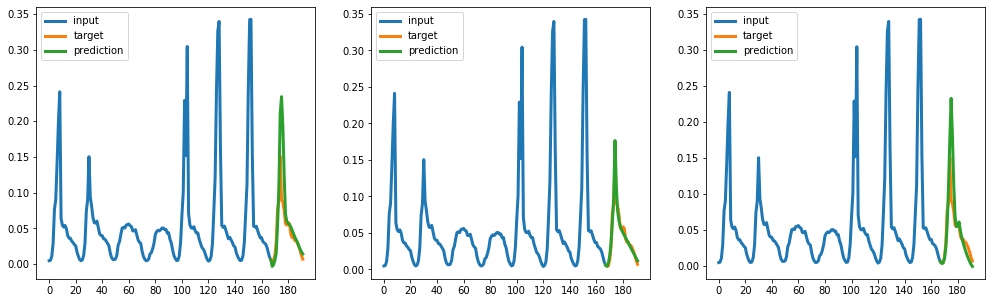

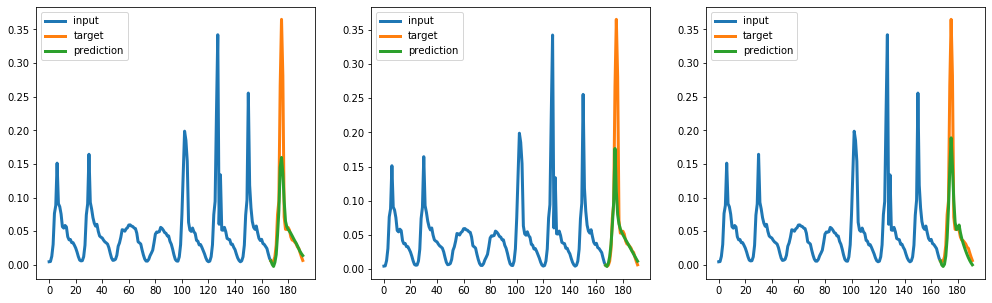

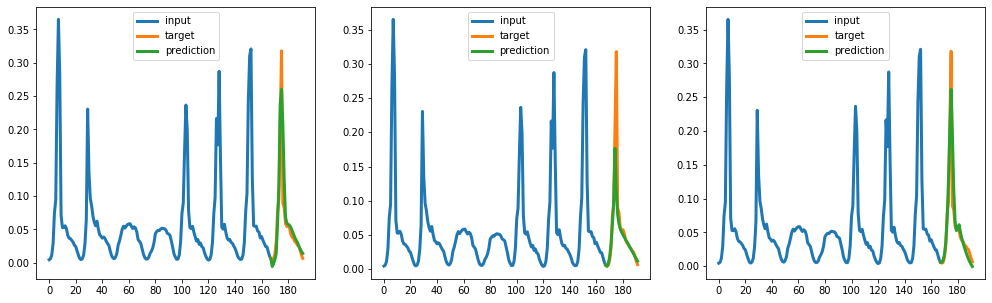

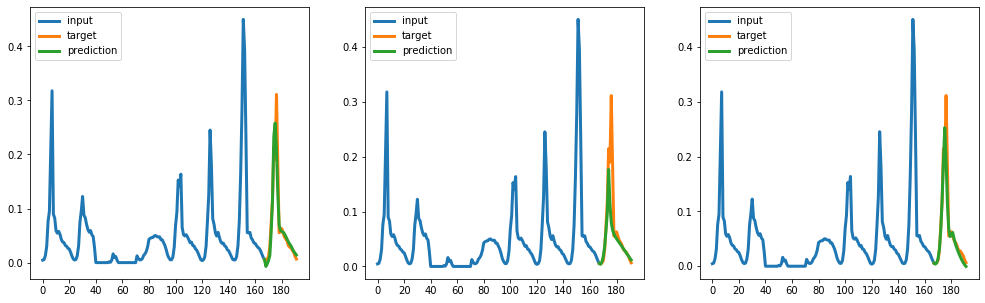

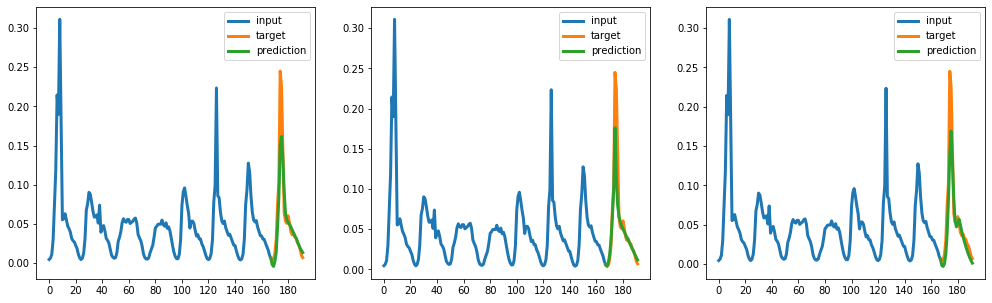

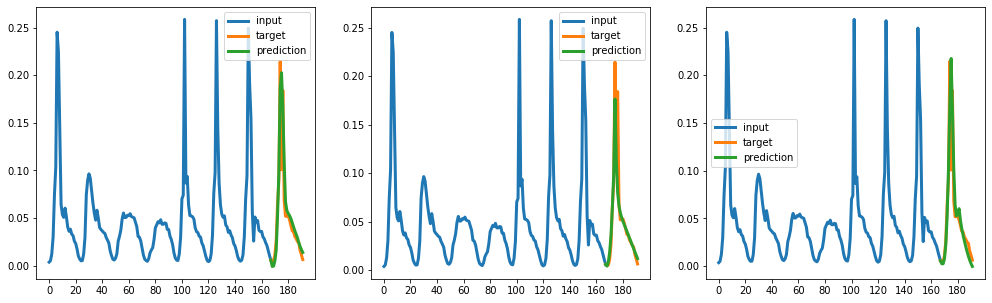

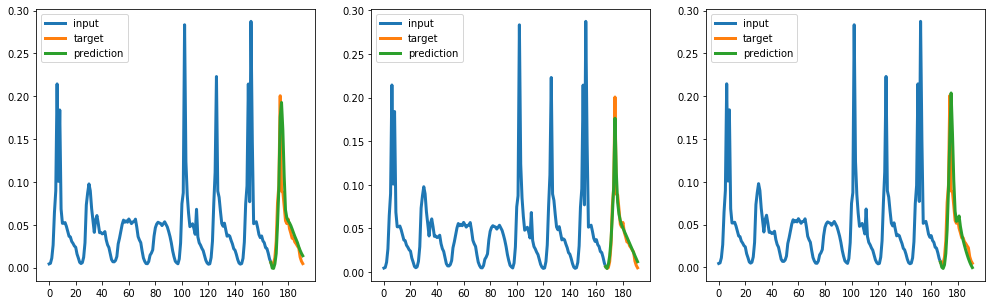

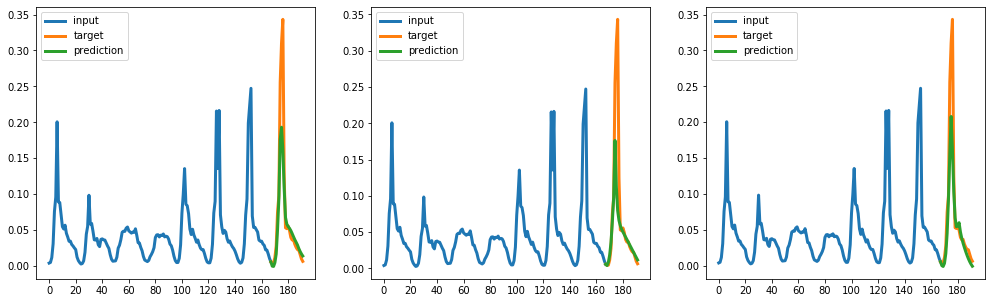

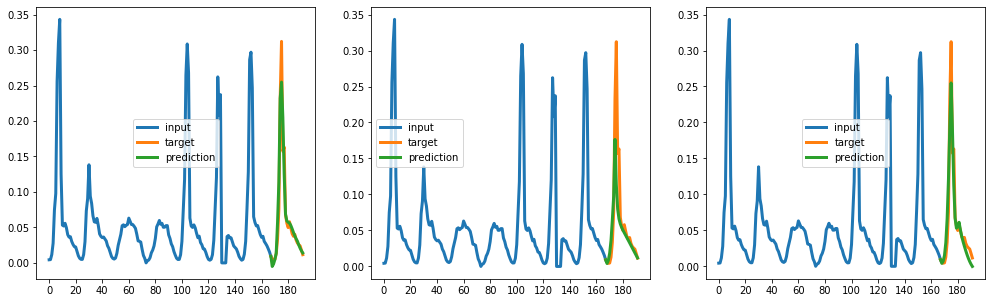

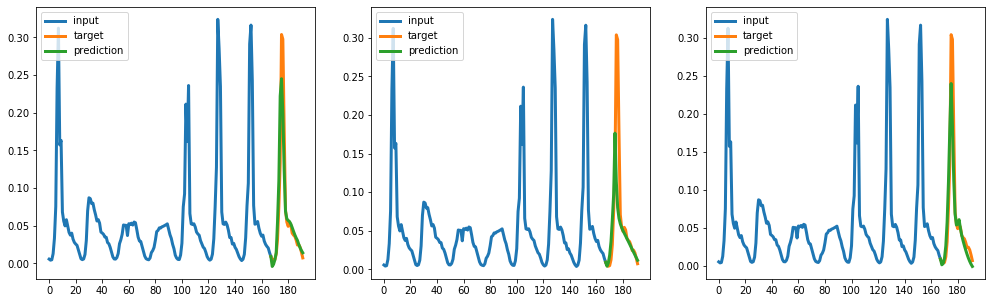

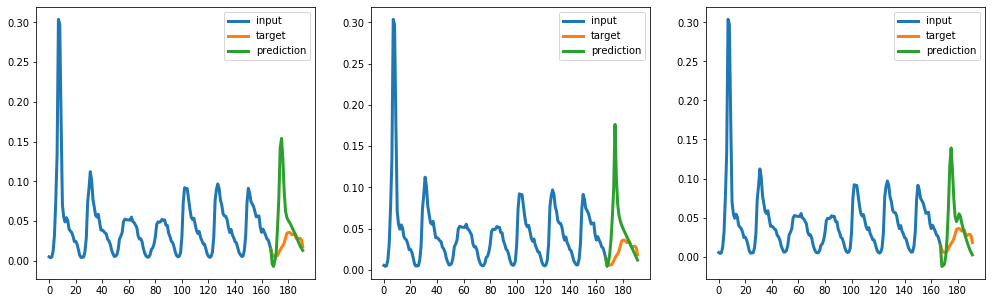

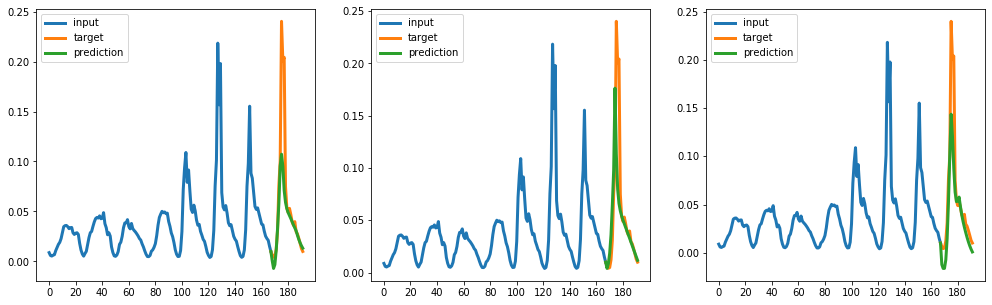

IndexError: index 25 is out of bounds for axis 0 with size 25

<Figure size 1224x360 with 0 Axes>

In [5]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate_shape,net_gru_dilate]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,N_input+N_output,20))
        plt.legend()
        k = k+1

    plt.show()